**Traffic signs classification using SIFT and visual bag of words**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


Install opencv for using SIFT

In [ ]:
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45


Import Required Librariers 

In [ ]:
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import pandas as pd
from google.colab import files


Functions implementation (Feature Extraction)


In [ ]:
#Get descriptors of keypoints in the image by using the SIFT Descriptor
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des
 #Stack descriptors together   
def stack(descriptor_list, clusters):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    kmeans = KMeans(n_clusters = clusters).fit(descriptors)
    return kmeans 
#Extract features from the clusters of the descriptors  
def extractFeatures(kmeans, descriptor_list, image_count, clusters):
    im_features = np.array([np.zeros(clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features
#Normalize extracted features so all of them exist on the same scale
def normalizeFeatures(scale, features):
    return scale.transform(features)   

Functions implementation (Get Image data)

In [ ]:
#Get path of the training and testing images and store images in images array
def getImages(datapath):
    CATEGORIES = ['0','1','2','3','4','5','6','7','8','9']
    for category in CATEGORIES:
      path = os.path.join(datapath, category)
      for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img)) 
    data = []
    for i in range(len(CATEGORIES)):
        category = CATEGORIES[i]
        path = os.path.join(datapath, category)
        for img in os.listdir(path):
            img_array = plt.imread(os.path.join(path,img))
            new_array = cv2.resize(img_array, (64, 64))
            data.append([new_array, i])
    t_data = np.array(data)
    return t_data
def classifier(im_features, train_labels):
    clf = RandomForestClassifier(n_estimators=100)
    #clf = LogisticRegression()
    #clf = GaussianNB()
    clf.fit(im_features, train_labels)
    return clf


Functions implementation (Display results)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
def plotHistogram(im_features, clusters):
    x_scalar = np.arange(clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Index")
    plt.ylabel("Frequency")
    plt.title("Visual Bag of Words")
    plt.xticks(x_scalar, x_scalar, color="black")
    plt.show()

def plotConfusions(true, predictions):
    class_names = ['0','1','2','3','4','5','6','7','8','9']
    print(classification_report(true, predictions, target_names=class_names))
    cnf_matrix = confusion_matrix(true, predictions)
    cm = confusion_matrix(true,predictions)
    print_confusion_matrix(cm,class_names)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print(TPR, "true positive rate")
# Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print(TNR, "true negative rate")
# Precision or positive predictive value
    PPV = TP/(TP+FP)
    print(PPV , "positive predictive value")
# Negative predictive value
    NPV = TN/(TN+FN)
    print(NPV , "Negative predictive value")
# Fall out or false positive rate
    FPR = FP/(FP+TN)
    print(FPR, "false positive rate")
# False negative rate
    FNR = FN/(TP+FN)
    print(FNR, "False negative rate")
# False discovery rate
    FDR = FP/(TP+FP)
    print(FDR)
# Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(ACC)

def Accuracy(true, predictions):
    print ('Testing Accuracy: %0.3f' % accuracy_score(true, predictions))

Training Model

In [ ]:
def trainModel():
    path = "/content/drive/MyDrive/TrainingData"
    clusters = 150
    images = getImages(path)
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    label_count = 10
    image_count = len(images)
    train_labels = np.array([])
    #for img_path in images:
    X = []
    y = []
    for features, label in images:
        #X.append(features)
        #print(label)
        y.append(label)
        X = np.array(X).reshape(-1, 64, 64, 3)
        train_labels = np.append(train_labels, y)
        #img = readImage(img_path)
        des = getDescriptors(sift, features)
        descriptor_list.append(des)

    kmeans = stack(descriptor_list, clusters)
    
    im_features = extractFeatures(kmeans, descriptor_list, image_count, clusters)
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    plotHistogram(im_features, clusters)
    clf = classifier(im_features, y)
    return kmeans, scale, clf, im_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


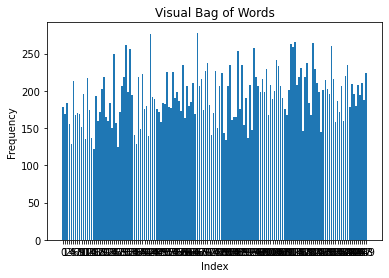

Features histogram plotted.
Training completed.


In [ ]:
kmeans, scale, clf, im_features = trainModel()


In [ ]:
lbl =	{ "0": "0","1": "1","2": "2","3": "3","4": "4","5": "5","6": "6","7": "7","8": "8","9": "9"
    }

Testing Model

In [ ]:
def testModel( kmeans, scale, clf, im_features):
    path = "/content/drive/MyDrive/TestingData"
    test_images = getImages(path)
    clusters = 150
    count = 0
    true = []
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    X = []
    y = []
    for features, label in test_images:
     y.append(label)
     X = np.array(X).reshape(-1, 64, 64, 3)
     des = getDescriptors(sift, features)
     if(des is not None):
         count += 1
         descriptor_list.append(des)   
    test_features = extractFeatures(kmeans, descriptor_list, count, clusters)
    test_features = scale.transform(test_features)  
    predictions = [lbl[str(int(i))] for i in clf.predict(test_features)]
    plotConfusions(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))
    #print ('Accuracy of testing data' % accuracy_score(true, predictions))
    Accuracy(np.array(y, dtype=np.string_),np.array(predictions, dtype=np.string_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


Test images classified.
['0', '0', '0', '0', '0', '0', '0', '0', '9', '0', '0', '0', '0', '0', '9', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '7', '2', '2', '1', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '6', '5', '6', '6', '5', '5', '6', '5', '5', '5', '5', '5', '5', '5', '5', '5', '9', '5', '6', '5', '4', '6', '6', '6', '6', '3', '6', '6', '6', '5', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', 

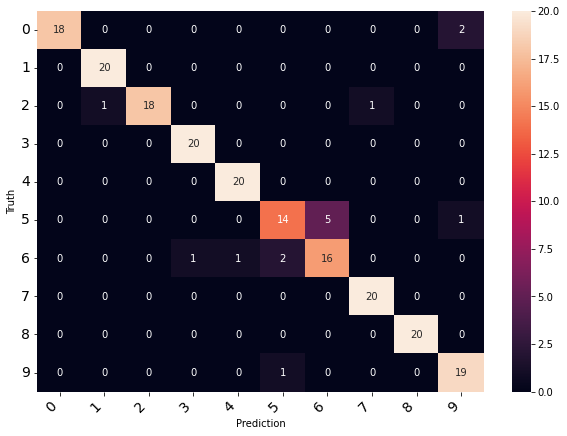

In [ ]:

testModel( kmeans, scale, clf, im_features)


In [ ]:

from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)